# Import and paths

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

sns.set_theme(context='paper')

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA = 'figer'
FAMILY = {
  'bbn' : [
          'CONTACT_INFO',
          'EVENT',
          'FACILITY',
          'GPE',
          'LOCATION',
          'ORGANIZATION',
          'PRODUCT',
          'SUBSTANCE',
          'WORK_OF_ART'],
  'figer' : ['art',
            'broadcast',
            'building',
            'computer',
            'education',
            'event',
            'finance',
            'geography',
            'government',
            'internet',
            'living_thing',
            'location',
            'medicine',
            'metropolitan_transit',
            'organization',
            'people',
            'person',
            'product',
            'rail',
            'religion',
            'transportation',
            'visual_art'],
  'ontonotes_shimaoka': [
          'location/geography',
          'location/structure',
          'location/transit',
          'organization/company',
          'other/art',
          # 'other/event',
          'other/health',
          'other/language',
          'other/living_thing',
          'other/product',
          'person/artist'
  ]
}

SUBSET = [10, 20, 40]
KB_MODE = ['bottom_up', 'top_down', 'hybrid']
if DATA != 'ontonotes_shimaoka':
  KB_MODE.append('horizontal')
METRIC = ['precision', 'recall', 'f1']
PROJECTOR = ['smart_init_classifier',
            'no_init_kenn_bottom_up',
            'no_init_kenn_top_down',
            'no_init_kenn_hybrid',
            'no_init_kenn_horizontal',
            'smart_init_box',
            'no_init_box_kenn_bottom_up',
            'no_init_box_kenn_top_down',
            'no_init_box_kenn_hybrid',
            'no_init_box_kenn_horizontal']
BACKBONE = ['classifier', 'box']


# set paths
# METRICS_FILE_PATH = f'../incremental/results/wandb_export/{DATA}/metrics_aggregated.csv'
METRICS_FILE_PATH = f'../incremental/results/wandb_export/{DATA}/metrics.csv'
# METRICS_FILE_PATH = './metrics.csv'
FIGURES_PATH = f'./figures/{DATA}'
TITLE = {
  'bbn' : 'BBN',
  'figer' : 'FIGER',
  'ontonotes_shimaoka' : 'OntoNotes'
}


# Utils

In [3]:
def filter_df(df, row_filter={}, stat=None):
  df_filtered = df.copy()
  for key, value in row_filter.items():
    if type(value) == list:
      df_filtered = df_filtered[df_filtered[key].isin(value)]
    else:
      df_filtered = df_filtered[df_filtered[key] == value]
  
  if stat:
    cols_filtered = ['projector', 'metric', 'subset', 'epoch'] + [c for c in df_filtered.columns if c.endswith(f'/{stat}')]
    df_filtered = df_filtered[cols_filtered]
  return df_filtered

# Read metrics

In [4]:
df_metrics = pd.read_csv(METRICS_FILE_PATH)
df_metrics['projector'] =df_metrics['projector'].apply(lambda x: x.replace('_adapter_bert_ms', ''))
df_metrics.fillna(0, inplace=True)
df_metrics

,metric,projector,instance,family,subset,precision,recall,f1,epoch
0,test/macro_example,no_init_box_kenn_horizontal,2,art,10,0.924577,0.904599,0.914479,36
1,test_incremental/macro_example_exclusive,no_init_box_kenn_horizontal,2,art,10,0.820513,0.641026,0.719748,36
2,test_pretraining/macro_example,no_init_box_kenn_horizontal,2,art,10,0.924577,0.904599,0.914479,36
3,test_incremental_only/micro,no_init_box_kenn_horizontal,2,art,10,0.772727,0.447368,0.566667,36
4,test_pretraining/macro_types,no_init_box_kenn_horizontal,2,art,10,0.887882,0.808841,0.846521,36
...,...,...,...,...,...,...,...,...,...
51952,test_incremental_visual_art/macro_types,smart_init_classifier,0,visual_art,40,1.000000,0.900000,0.947368,12
51953,test/micro,smart_init_classifier,0,visual_art,40,0.912976,0.899561,0.906219,12
51954,test_pretraining/micro,smart_init_classifier,0,visual_art,40,0.912976,0.899561,0.906219,12
51955,test_incremental/macro_types,smart_init_classifier,0,visual_art,40,0.905405,0.950000,0.927167,12


In [5]:
# keep only projectors needed for the paper
df_metrics = filter_df(df_metrics, {'projector' : PROJECTOR})
df_metrics['projector'] = df_metrics['projector'].apply(lambda x : x.replace('no_init_', '').replace('smart_init_', ''))
# assign type of projector
df_metrics['projector_type'] = df_metrics['projector'].apply(lambda x : 'box' if 'box' in x else 'classifier')

In [6]:
df_metrics[df_metrics['metric'] == 'test_incremental_only/macro_types']['family'].value_counts()

art                     90
broadcast               90
transportation          90
religion                90
rail                    90
product                 90
person                  90
people                  90
organization            90
metropolitan_transit    90
medicine                90
location                90
living_thing            90
internet                90
government              90
geography               90
finance                 90
event                   90
education               90
computer                90
building                90
visual_art              90
Name: family, dtype: int64

In [7]:
(df_metrics['metric'] == 'test_incremental_only/macro_types').sum() # / len(FAMILY[DATA]) / 3 / 3

1980

# Create tables

### Table F1 of families (without father) aggregated

In [8]:
df_metrics[(df_metrics['metric'].apply(lambda x : 'incremental_only/macro_types' in x))] \
  .groupby(['projector', 'subset']).mean().drop('instance', axis=1)

precision    recall        f1      epoch
projector           subset                                          
box                 10       0.510918  0.819274  0.522787  24.227273
                    20       0.528997  0.877117  0.565715  29.393939
                    40       0.599752  0.876072  0.643524  37.878788
box_kenn_bottom_up  10       0.789166  0.536778  0.584604  55.757576
                    20       0.779542  0.718550  0.699915  41.469697
                    40       0.759849  0.793160  0.738659  39.575758
box_kenn_horizontal 10       0.700205  0.462441  0.436918  54.893939
                    20       0.720928  0.604443  0.592437  42.878788
                    40       0.752188  0.726785  0.704790  41.863636
box_kenn_hybrid     10       0.783353  0.543736  0.587450  55.060606
                    20       0.774134  0.717177  0.698383  39.393939
                    40       0.770022  0.793479  0.740539  36.954545
box_kenn_top_down   10       0.784651  0.610612  0.644328  54.060606
                    20       0.759205  0.771059  0.721197  39.924242
                    40       0.717423  0.831133  0.729251  36.424242
classifier          10       0.569942  0.758425  0.594921  16.787879
                    20       0.608547  0.844162  0.650388  17.848485
                    40       0.659993  0.875650  0.721557  17.333333
kenn_bottom_up      10       0.667610  0.787629  0.676419  77.530303
                    20       0.609615  0.869571  0.666551  43.636364
                    40       0.577402  0.897084  0.643151  23.030303
kenn_horizontal     10       0.670834  0.765836  0.675879  77.151515
                    20       0.620231  0.858973  0.692447  42.833333
                    40       0.564680  0.891952  0.645092  23.833333
kenn_hybrid         10       0.692913  0.787239  0.690499  76.681818
                    20       0.637164  0.871067  0.696698  41.409091
                    40       0.592583  0.897913  0.658357  22.939394
kenn_top_down       10       0.594444  0.797345  0.606053  81.424242
                    20       0.532143  0.870835  0.600098  45.924242
                    40       0.508968  0.904553  0.586568  23.969697

### Table F1 of single types aggregated

In [9]:
# get columns
metrics = list(df_metrics['metric'].value_counts().keys())
metrics_single_types = []
for metric in metrics:
  # if the metric is referred to a single type
  if metric.startswith('test_incremental') \
    and not metric.startswith('test_incremental_only') \
    and not metric.startswith('test_incremental/'):
    for family in FAMILY[DATA]:
      # exclude metrics that aggregate father and sons
      family_str = family.replace('/', '-')
      if family_str in metric and not metric.startswith(f"test_incremental_{family_str}/"):
        metrics_single_types.append(metric)
metrics_single_types = list(set(metrics_single_types))
# filter
df_f1_single_types = df_metrics[df_metrics['metric'].isin(metrics_single_types)].drop('instance', axis=1)
# compute stats 
df_f1_mean = df_f1_single_types.groupby(['projector', 'subset']).mean().reset_index().sort_values(['subset', 'projector'])
df_f1_std = df_f1_single_types.groupby(['projector', 'subset']).std().reset_index().sort_values(['subset', 'projector'])
# recompute f1 starting from averaged precision and recall
df_f1_mean['f1'] = 2 * df_f1_mean['precision'] * df_f1_mean['recall'] / (df_f1_mean['precision'] + df_f1_mean['recall'])
# change colnames and convert subset to k-shot
df_f1_mean.columns = ['projector', 'shots', 'precision/mean', 'recall/mean', 'f1/mean', 'epoch/mean']
df_f1_std.columns = ['projector', 'shots', 'precision/std', 'recall/std', 'f1/std', 'epoch/std']
df_f1_mean['shots'] = df_f1_mean['shots'].apply(lambda x: int(x/2))
df_f1_std['shots'] = df_f1_std['shots'].apply(lambda x: int(x/2))
# merge dfs
df_f1_agg = pd.merge(left=df_f1_mean, right=df_f1_std, left_on=['projector', 'shots'], right_on=['projector', 'shots'])
# remove columns
df_f1_agg = df_f1_agg.drop(['precision/mean', 'recall/mean', 'precision/std', 'recall/std'], axis=1)
# transpose
rows_t = defaultdict(dict)
for i, row in df_f1_agg.iterrows():
  rows_t[row['projector']].update({
    'projector': row['projector'],
    f"{row['shots']}/f1/mean" : round(row['f1/mean'], 3),
    f"{row['shots']}/f1/std" : round(row['f1/std'], 3),
  })
df_f1_agg_t = pd.DataFrame(rows_t.values())
# save
out_dir = './tables'
os.makedirs(out_dir, exist_ok=True)
out_file = f'{DATA}_macro_types.csv'
df_f1_agg_t.to_csv(os.path.join(out_dir, out_file), index=False)

In [10]:
df_f1_agg_t[df_f1_agg_t['projector'].apply(lambda x : 'box' not in x)]

,projector,5/f1/mean,5/f1/std,10/f1/mean,10/f1/std,20/f1/mean,20/f1/std
5,classifier,0.387,0.306,0.474,0.329,0.645,0.316
6,kenn_bottom_up,0.670,0.253,0.723,0.242,0.727,0.242
7,kenn_horizontal,0.678,0.245,0.714,0.218,0.720,0.221
8,kenn_hybrid,0.683,0.256,0.724,0.239,0.728,0.239
9,kenn_top_down,0.630,0.279,0.652,0.274,0.668,0.263


In [11]:
df_f1_agg_t[df_f1_agg_t['projector'].apply(lambda x : 'box' in x)]

,projector,5/f1/mean,5/f1/std,10/f1/mean,10/f1/std,20/f1/mean,20/f1/std
0,box,0.376,0.263,0.422,0.297,0.612,0.337
1,box_kenn_bottom_up,0.615,0.338,0.710,0.347,0.736,0.320
2,box_kenn_horizontal,0.539,0.333,0.579,0.367,0.650,0.355
3,box_kenn_hybrid,0.614,0.342,0.703,0.353,0.738,0.322
4,box_kenn_top_down,0.650,0.343,0.722,0.352,0.737,0.318


# Create plots

## F1 improvements histograms

Alternative: aggregate datasets to show 2 complete figures, then put the 6 single dataset figures in appendix???

In [12]:
def compute_delta_f1(row, df_baseline):
    row_filter = {
        'projector': row['projector_type'],
        'subset': row['subset'],
        'type': row['type']
    }
    df_tmp = filter_df(df_baseline, row_filter)
    if df_tmp.shape[0] == 1:
        f1_baseline = df_tmp.iloc[0]['f1']
        delta_f1 = row['f1'] - f1_baseline
        return delta_f1
    else:
        return 'Error: metric mismatch'

In [13]:
# copy df from previous cell
df_tmp = df_f1_single_types.drop(['precision', 'recall', 'epoch'], axis=1).copy()
# aggregate
df_tmp_agg = df_tmp.groupby(['metric','subset','projector', 'family'], as_index=False).mean()
# prepare new columns
df_tmp_agg['projector_type'] = df_tmp_agg['projector'].apply(lambda x : 'box' if 'box' in x else 'classifier')
df_tmp_agg['type'] = df_tmp_agg['metric'].apply(lambda x : '/'.join(x.split('/')[0].split('-')[1:]))
df_tmp_agg['type'] = '/' + df_tmp_agg['family'] + '/' + df_tmp_agg['type']
# df_tmp_agg = df_tmp_agg.drop(['metric', 'family'], axis=1)
df_tmp_agg = df_tmp_agg.drop(['metric'], axis=1)
# prepare baseline df
df_agg_baseline = df_tmp_agg[df_tmp_agg['projector'] == df_tmp_agg['projector_type']]
# prepare kenn df
df_improvements = df_tmp_agg[df_tmp_agg['projector'] != df_tmp_agg['projector_type']]
df_improvements
# compute delta_f1 as f1(projector_kenn) - f1(projector)
df_improvements['delta_f1'] = df_improvements.apply(lambda x : compute_delta_f1(x, df_agg_baseline), axis=1)# x['f1'], raw=True)
# convert colnames
df_improvements.rename({'subset': 'k', 'projector': 'KB', 'delta_f1': 'Delta F1', 'f1': 'F1'}, axis=1, inplace=True)
df_improvements['k'] = df_improvements['k'].apply(lambda x : int(x / 2))
df_improvements['KB'] = df_improvements['KB'].apply(lambda x : x.split('kenn')[1][1:].replace('_', ' '))
df_improvements


,k,KB,family,F1,projector_type,type,Delta F1
1,5,bottom up,art,0.482079,box,/art/film,-0.143821
2,5,horizontal,art,0.471129,box,/art/film,-0.154771
3,5,hybrid,art,0.512480,box,/art/film,-0.113420
4,5,top down,art,0.581705,box,/art/film,-0.044195
6,5,bottom up,art,0.504313,classifier,/art/film,-0.113329
...,...,...,...,...,...,...,...
2364,20,top down,visual_art,0.807692,box,/visual_art/,0.000000
2366,20,bottom up,visual_art,0.947368,classifier,/visual_art/,0.000000
2367,20,horizontal,visual_art,0.947368,classifier,/visual_art/,0.000000
2368,20,hybrid,visual_art,0.947368,classifier,/visual_art/,0.000000


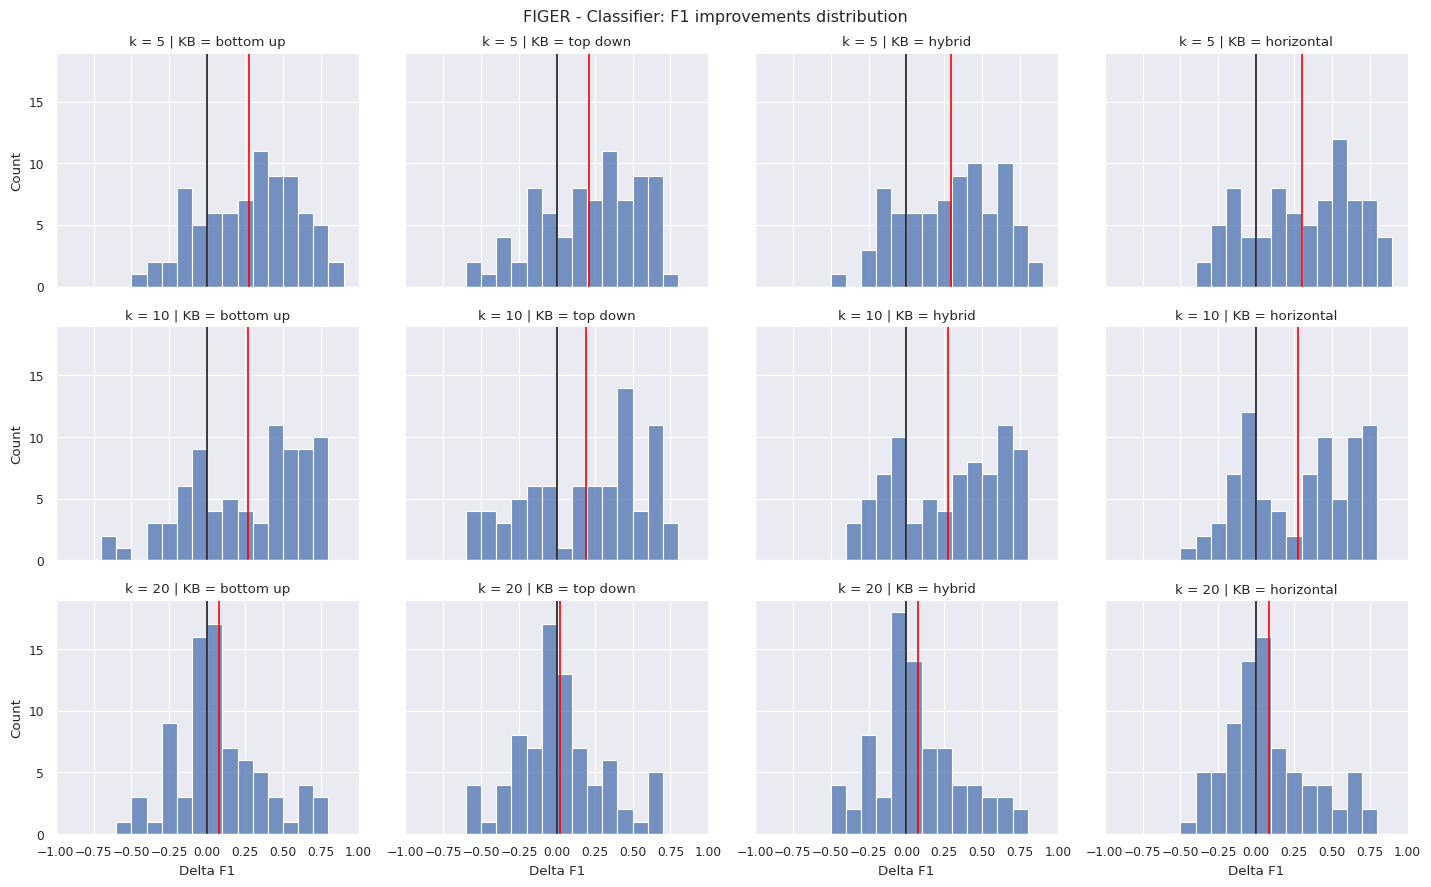

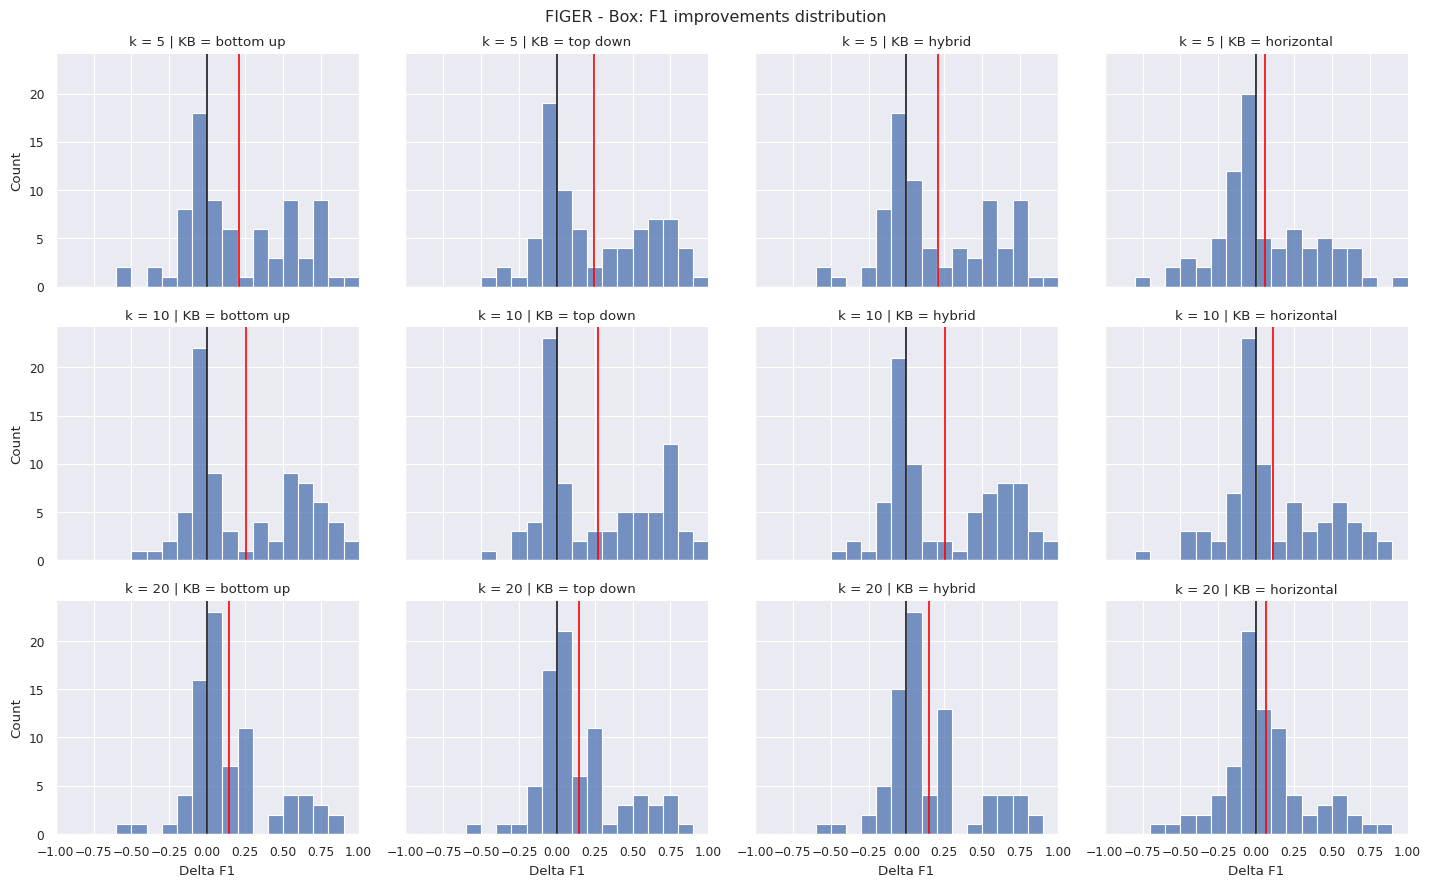

In [14]:
# barplot of improvements
transpose = False
if transpose:
  col = 'k'
  row = 'KB'
  col_order = [5, 10, 20]
else:
  col = 'KB'
  row = 'k'
  col_order = ['bottom up', 'top down', 'hybrid', 'horizontal']

# plot
for backbone in BACKBONE:
  df_filtered = df_improvements[df_improvements['projector_type'] == backbone]
  # prepare grid
  fg = sns.FacetGrid(df_filtered, row=row, col=col, xlim=(-1, 1), height=3, aspect=1.2, col_order=col_order)
  
  title = f'{TITLE[DATA]} - {backbone.title()}: F1 improvements distribution'
  fg.fig.suptitle(title)
  
  # draw hist
  fg.map_dataframe(sns.histplot, x='Delta F1', bins=20, binrange=(-1, 1), kde=False)
  # fix yticks
  for ax_row in fg.axes:
    for ax in ax_row:
      ax.locator_params(axis='y', integer=True)
  
  # draw x = 0 line
  fg.map(plt.axvline, x=0, color='k')
  
  # draw x = mean line
  df_filtered_mean = df_filtered.groupby(['KB', 'k'], as_index=False).mean()
  df_filtered_median = df_filtered.groupby(['KB', 'k'], as_index=False).median()
  for ax_row in fg.axes:
    for hp in ax_row:
      k = int(hp.get_title().split('|')[0].replace('k = ', '').strip())
      kb = hp.get_title().split('|')[1].replace('KB = ', '').strip()
      x_mean = df_filtered_mean[(df_filtered_mean['k'] == k) & (df_filtered_mean['KB'] == kb)].iloc[0]['Delta F1']
      x_mean_line = hp.axvline(x=x_mean, color='red')
      # x_median = df_filtered_median[(df_filtered_median['k'] == k) & (df_filtered_mean['KB'] == kb)].iloc[0]['Delta F1']
      # x_median_line = hp.axvline(x=x_median, color='blue')

  plt.show()

## F1 improvements per family: count bar + total bar + percentage

In [15]:
def count_improvements(df_complete, row_agg):
    df = filter_df(df_complete, {'Family': row_agg['Family'], 'KB': row_agg['KB'], 'k': row_agg['k'], 'projector_type': row_agg['projector_type']})
    df_imp = df[df['Delta F1'] > 0]
    return df_imp.shape[0]

def count_types(df_complete, row_agg):
    df = filter_df(df_complete, {'Family': row_agg['Family'], 'KB': row_agg['KB'], 'k': row_agg['k'], 'projector_type': row_agg['projector_type']})
    return df.shape[0]


In [16]:
# convert improvements to percentages
df_improvements_perc = df_improvements.copy()
df_improvements_perc['Delta F1'] = df_improvements_perc.apply(lambda x : x['Delta F1'] / x['F1'] * 100 if x['F1'] != 0 else float('inf') * x['Delta F1'], axis=1)
# fix colnames
df_improvements_perc.rename({'family': 'Family'}, axis=1, inplace=True)
# aggregate by family and count positive improvements
df_improvements_perc_agg = df_improvements_perc.groupby(['Family', 'KB', 'k', 'projector_type'], as_index=False).mean()
# count positive improvements
df_improvements_perc_agg['# improvements'] = df_improvements_perc_agg.apply(
                                            (lambda x : count_improvements(df_improvements_perc, x)),
                                            axis=1)
# count total subtypes per family
df_improvements_perc_agg['# types'] = df_improvements_perc_agg.apply(
                                            (lambda x : count_types(df_improvements_perc, x)),
                                            axis=1)


df_improvements_perc_agg.tail(5)

,Family,KB,k,projector_type,F1,Delta F1,# improvements,# types
523,visual_art,top down,5,classifier,0.864864,-5.265298,0,2
524,visual_art,top down,10,box,0.853098,-0.232594,0,2
525,visual_art,top down,10,classifier,0.854358,-6.166344,0,2
526,visual_art,top down,20,box,0.852378,-0.876928,0,2
527,visual_art,top down,20,classifier,0.782445,-21.629677,0,2


In [25]:
df_tmp[df_tmp['Delta F1'] == float('-inf')]

,Family,KB,k,projector_type,F1,Delta F1,# improvements,# types
78,computer,horizontal,5,box,0.322312,-inf,1,2
80,computer,horizontal,10,box,0.412111,-inf,0,2


In [29]:
bar, kb, f, perc_delta

(<matplotlib.patches.Rectangle at 0x7f3f6e40f220>, 'horizontal', 'event', nan)

In [33]:
filter_df(df_tmp, {'KB': kb, 'Family': f, 'k': int(bp.get_title().split(' ')[-1])})

,Family,KB,k,projector_type,F1,Delta F1,# improvements,# types
126,event,horizontal,5,box,0.30429,NaN,3,7


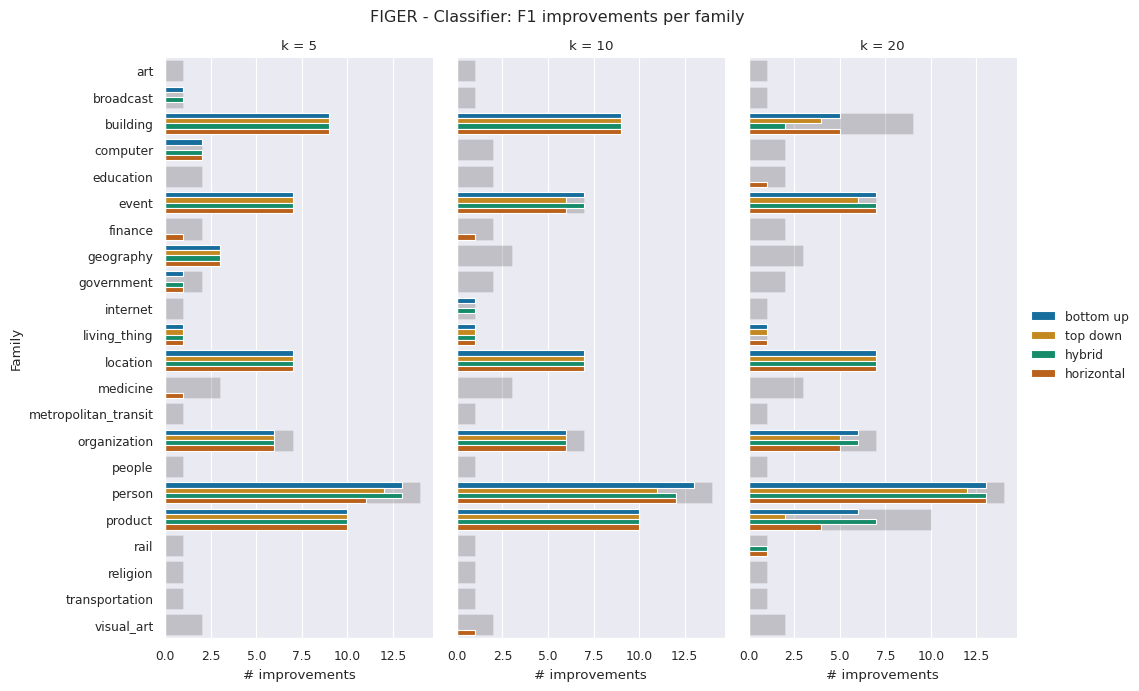

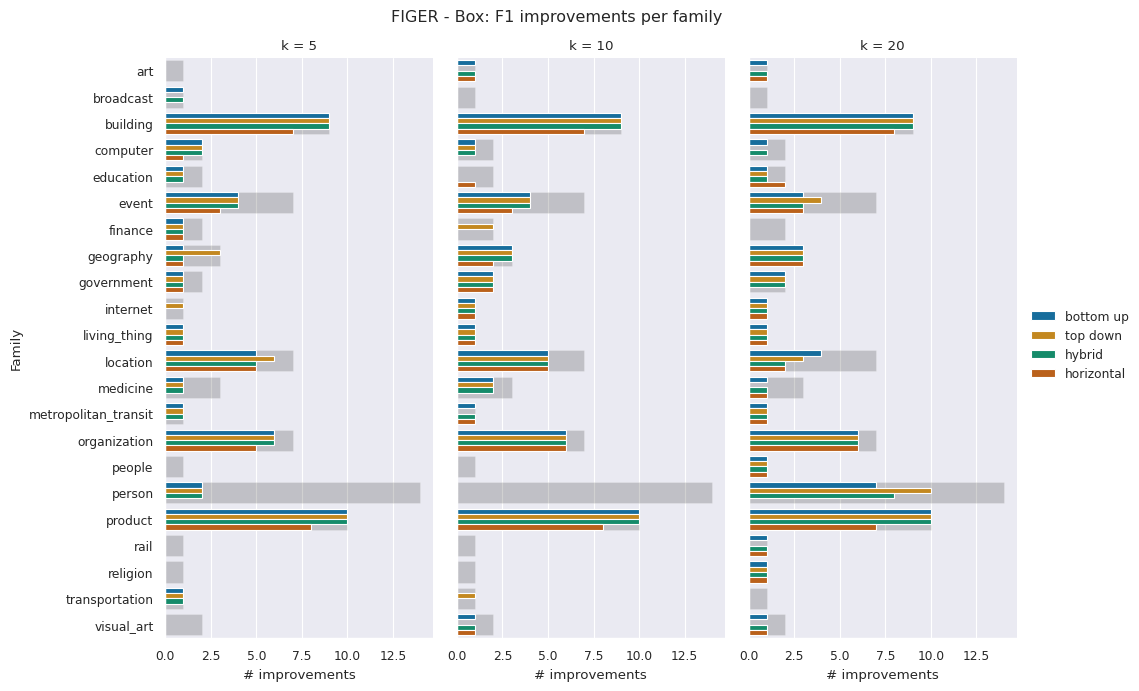

In [34]:
hue_order = ['bottom up', 'top down', 'hybrid', 'horizontal']
col_order = [5, 10, 20]
if DATA == 'figer':
  height = 7
  aspect = .5
else:
  height = 5
  aspect = .5

# draw multi barplots
for backbone in BACKBONE:
  # prepare df filtered by backbone
  df_tmp = df_improvements_perc_agg[df_improvements_perc_agg['projector_type'] == backbone]
  # prepare grid
  fg = sns.FacetGrid(data=df_tmp, col='k', col_order=col_order, height=height, aspect=aspect, legend_out=True)
  title = f'{TITLE[DATA]} - {backbone.title()}: F1 improvements per family'
  fg.fig.suptitle(title)
  # prepare subplot
  fg.map_dataframe(sns.barplot, data=df_tmp, y='Family', x='# types', orient='horizontal', errorbar=None, color='k', alpha=.2)
  fg.map_dataframe(sns.barplot, data=df_tmp, y='Family', x='# improvements', hue='KB', hue_order=hue_order, orient='horizontal', errorbar=None, palette='colorblind')
  fg.add_legend()
  
  # for ax_row in fg.axes:
  #   for bp in ax_row:
  #     # fix xticks
  #     ax.locator_params(axis='x', integer=True)
  #     for container in bp.containers[1:]:
  #         kb = container.get_label()
  #         perc_deltas = []
  #         for f in FAMILY[DATA]:
  #           perc_delta = filter_df(df_tmp, {'KB': kb, 'Family': f, 'k': int(bp.get_title().split(' ')[-1])})['Delta F1'].iloc[0]
  #           if perc_delta == float('inf'):
  #             perc_deltas.append('inf')
  #           elif perc_delta == float('-inf'):
  #             perc_deltas.append('-inf')
  #           else:
  #             perc_deltas.append(int(perc_delta))
          
  #         for idx, bar in enumerate(container.get_children()):
  #           xy = bar.get_xy()
  #           # xy = (xy[0] + bar.get_width() + .6, xy[1] + bar.get_height() + .12)
  #           xy = (xy[0], xy[1] + bar.get_height() + .105)
  #           bp.annotate(f'{perc_deltas[idx]}%',
  #                           fontsize=6,
  #                           color='black',
  #                           xy=xy,
  #                           xytext=(0, 3), # 3 points vertical offset
  #                           textcoords="offset points",
  #                           ha='center', va='bottom')
  plt.show()

## F1 measure per family

In [36]:
# aggregate family
# df_f1_family = df_f1_single_types.groupby(['family', 'projector', 'subset', 'projector_type'], as_index=False).mean()
df_f1_family = df_f1_single_types.copy()
# convert colnames
df_f1_family.rename({'subset': 'k', 'projector': 'KB', 'f1': 'F1', 'family': 'Family'}, axis=1, inplace=True)
df_f1_family['k'] = df_f1_family['k'].apply(lambda x : int(x / 2))
df_f1_family['KB'] = df_f1_family['KB'].apply(lambda x : x.split('kenn')[1][1:].replace('_', ' ') if x not in ['box', 'classifier'] else '-')
df_f1_family.head(5)


,metric,KB,Family,k,precision,recall,F1,epoch,projector_type
10,test_incremental_art-film/macro_types,horizontal,art,5,0.772727,0.447368,0.566667,36,box
26,test_incremental_art-film/macro_types,horizontal,art,5,0.875000,0.184211,0.304348,72,box
42,test_incremental_art-film/macro_types,horizontal,art,5,0.761905,0.421053,0.542373,40,box
58,test_incremental_art-film/macro_types,hybrid,art,5,0.818182,0.473684,0.600000,46,box
74,test_incremental_art-film/macro_types,top down,art,5,0.685714,0.631579,0.657534,47,box


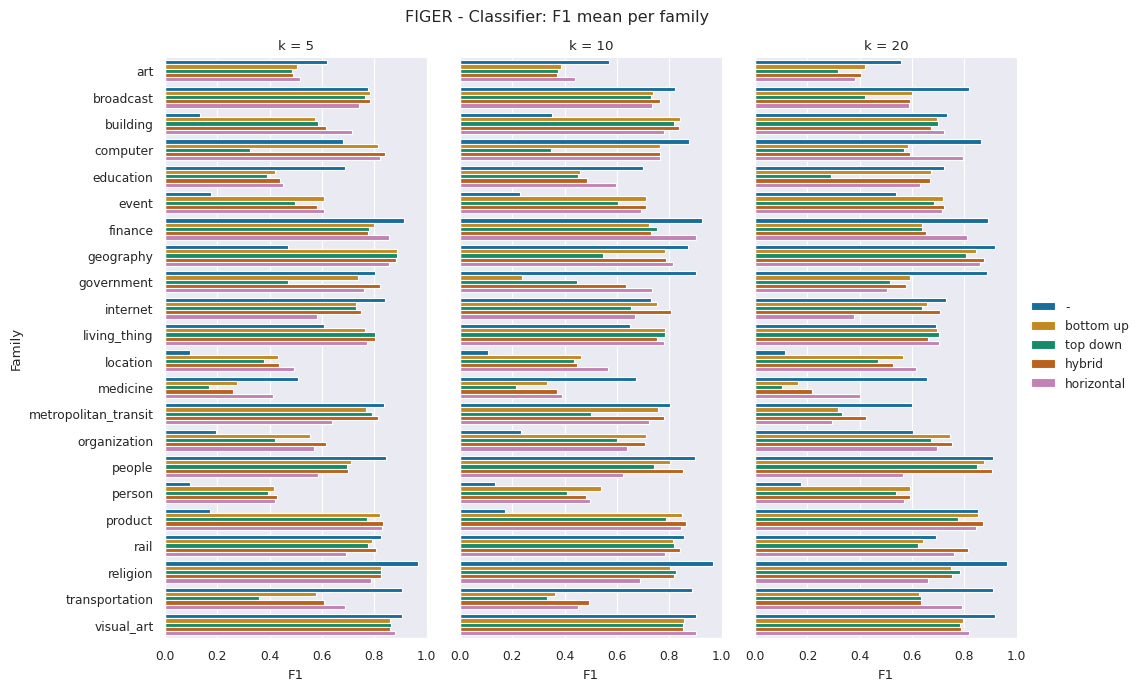

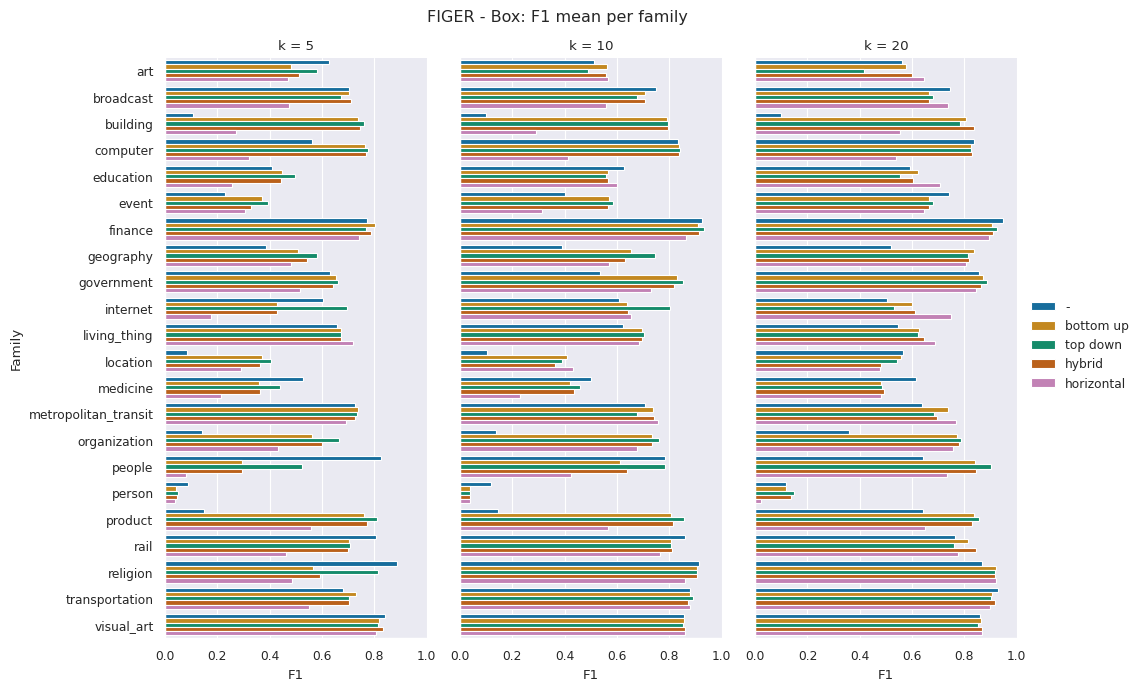

In [58]:
hue_order = ['-', 'bottom up', 'top down', 'hybrid', 'horizontal']
col_order = [5, 10, 20]
if DATA == 'figer':
  height = 7
  aspect = .5
else:
  height = 5
  aspect = .5

# draw barplots
for backbone in ['classifier', 'box']:
  # prepare df filtered by backbon
  df_tmp = df_f1_family[df_f1_family['projector_type'] == backbone]
  # prepare grid
  fg = sns.FacetGrid(data=df_tmp, col='k', col_order=col_order, height=height, aspect=aspect, legend_out=True, xlim=(0, 1))
  title = f'{TITLE[DATA]} - {backbone.title()}: F1 mean per family'
  fg.fig.suptitle(title)
  # prepare subplot
  fg.map_dataframe(sns.barplot, data=df_tmp, y='Family', x='F1', hue='KB', hue_order=hue_order, orient='horizontal', errorbar=None, palette='colorblind')
  fg.add_legend()
  plt.show()

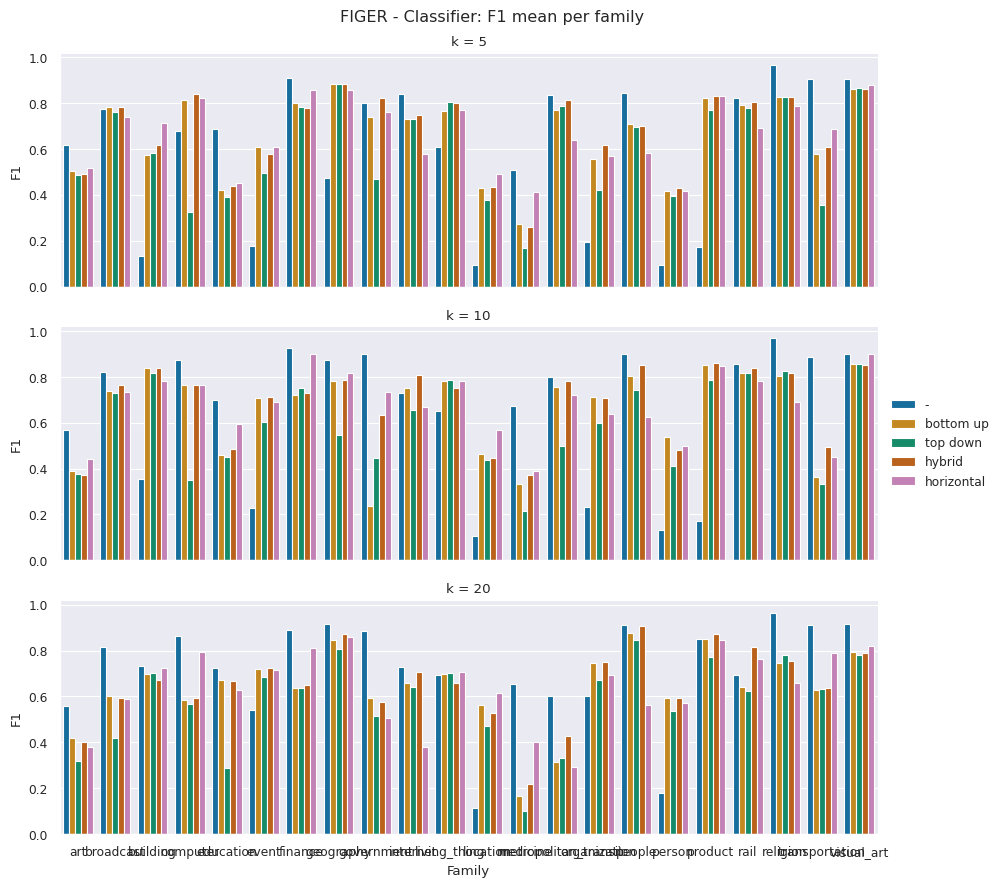

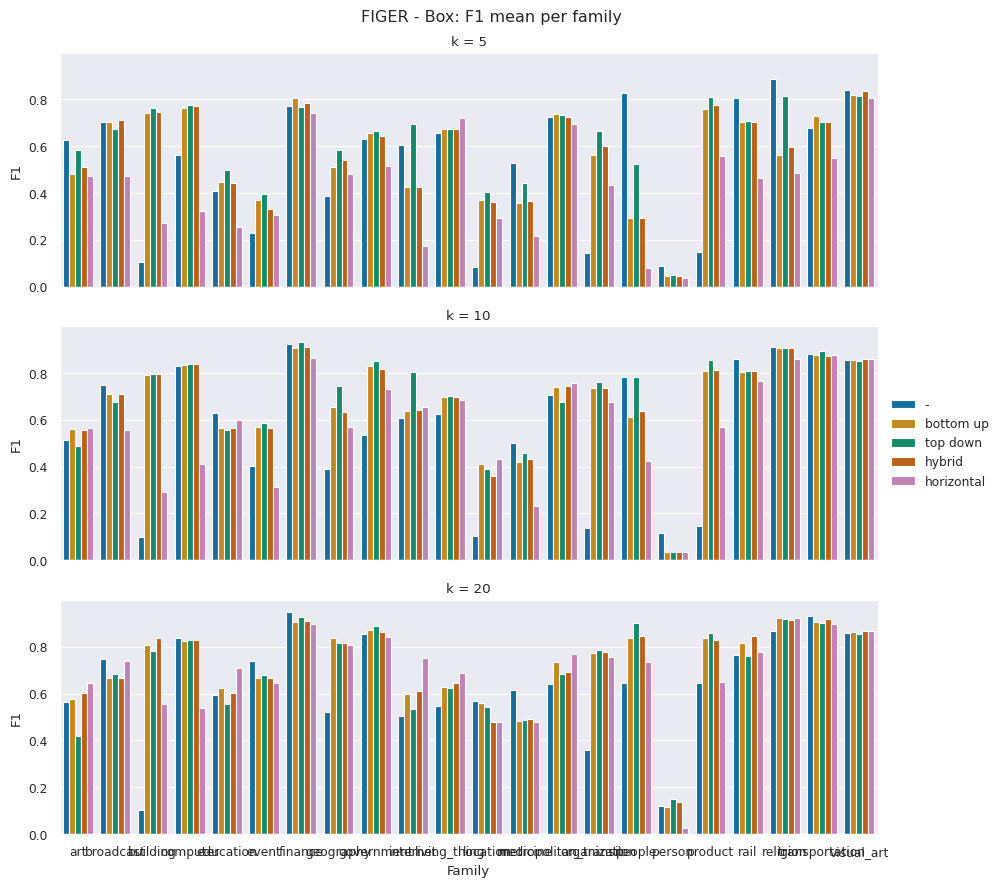

In [55]:
hue_order = ['-', 'bottom up', 'top down', 'hybrid', 'horizontal']
col_order = [5, 10, 20]
if DATA == 'figer':
  height = 3
  aspect = 3
else:
  height = 5
  aspect = .5

# draw barplots
for backbone in ['classifier', 'box']:
  # prepare df filtered by backbon
  df_tmp = df_f1_family[df_f1_family['projector_type'] == backbone]
  # prepare grid
  fg = sns.FacetGrid(data=df_tmp, row='k', col_order=col_order, height=height, aspect=aspect, legend_out=True, xlim=(0, 1))
  title = f'{TITLE[DATA]} - {backbone.title()}: F1 mean per family'
  fg.fig.suptitle(title)
  # prepare subplot
  fg.map_dataframe(sns.barplot, data=df_tmp, x='Family', y='F1', hue='KB', hue_order=hue_order, orient='vertical', errorbar=None, palette='colorblind')
  fg.add_legend()
  plt.show()